In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!git clone https://github.com/parth1620/object-localization-dataset.git
!pip install timm

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3mzspvsd
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3mzspvsd
  Resolved https://github.com/albumentations-team/albumentations to commit 6f7bc1da9fd37f8471bdeb6dd6b328dd6033a098
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 39.1 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.6-py3-none-any.whl size=155665 sha256=fe43be9560b26b0b73ced3bdb4d57aa2f0b129d1d37702c9770c63c5d49825cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_cs6k7oi/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
!ls drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets

/content
 Eggplant_Dataset.csv	 test.csv				     train.csv
 images			'test(EGGPLANT_ONLY).csv'		    'train(EGGPLANT_ONLY).csv'
 sample_submission.csv	'test(EGGPLANT_ONLY_WITH_COORDINATES).csv'   train.gsheet


In [4]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.models import resnet50, ResNet50_Weights
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm.notebook import tqdm
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import cv2
import sys
sys.path.append('/content/object-localization-dataset')
import utils

In [5]:
CSV_FILE_TRAIN = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/train.csv"
CSV_FILE_TEST = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/test.csv"
IMAGE_DIR = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/images"
#EGGPLANT_CSV_FILE_TRAIN = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/train(EGGPLANT_ONLY).csv"
#EGGPLANT_CSV_FILE_TEST = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/test(EGGPLANT_ONLY_WITH_COORDINATES).csv"
EGGPLANT_CSV_FILE_TRAIN = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/Eggplant_Dataset.csv"

BATCH_SIZE = 3
IMAGE_SIZE = 180
LEARNING_RATE = 0.01
EPOCHS = 40
MODEL_NAME = "resnet50"

NUMBER_OF_COORDINATES = 4
THRESHOLD = 0.5
dfTrain = pd.read_csv(EGGPLANT_CSV_FILE_TRAIN)
#dfTest = pd.read_csv(EGGPLANT_CSV_FILE_TEST)
dfTrain
#dfTest


,filename,xmin,ymin,xmax,ymax
0,img_164.jpg,56,85,171,182
1,img_101.jpg,19,42,213,186
2,img_185.jpg,5,12,190,209
3,img_76.jpg,36,72,205,187
4,img_116.jpg,62,76,171,191
...,...,...,...,...,...
56,img_53.jpg,35,35,204,153
57,img_62.jpg,49,49,199,197
58,img_75.jpg,38,52,199,199
59,img_80.jpg,17,50,210,168


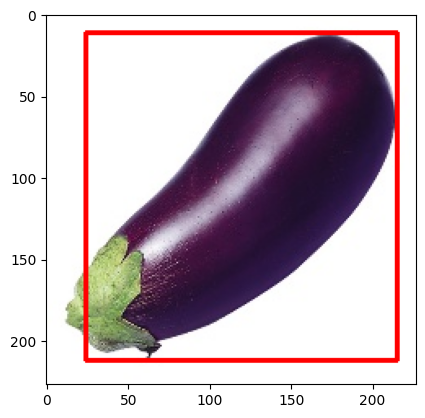

In [6]:
row = dfTrain.iloc[17] #get row 17 from the train dataset
img = cv2.imread(IMAGE_DIR + "/" + row.filename)#read the image in row index 17
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#convert image from BGR color space to RGB color space
upLeftPoint = (row.xmin, row.ymin) #upper left point of the bounding box coordinates
lowRightPoint = (row.xmax, row.ymax) #lower right point of the bounding box coordinates
bounding_box_img = cv2.rectangle(img, upLeftPoint, lowRightPoint, (255, 0, 0), 2)#cv2.rectangle creates bounding box with coordinates upLeftPoint, lowRightPoint and gives it the color (255, 0, 0) which is red and line size of bounding box is 2
plt.imshow(bounding_box_img)#plot the image with bounding box included

In [7]:
train_df, valid_df = train_test_split(dfTrain, test_size=0.20, random_state=42)

In [8]:
#data augmentation for the training dataset
train_aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),#Resize all the images
    A.HorizontalFlip(p=0.5),#horizontal flip with a probability of horizontally flipping being 0.5
    A.VerticalFlip(p=0.5),#Vertical flip with a probability of vertically flipping being 0.5
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))#since this is an object localization task we need to mention bounding box parameters A.BboxParams() and we also have to specify the label_field

#data augmentation for the validation dataset
#we just use Resize for validation augmentation because validation won't do any other augmentation
valid_aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),#Resize all the images
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))#since this is an object localization task we need to mention bounding box parameters A.BboxParams() and we also have to specify the label_field

In [9]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):#By default the augmentations are going to be None
    self.df = df
    self.augmentations = augmentations

  def __len__(self): #This method is going to return the length of the dataset
    return len(self.df)

  def __getitem__(self, idx):#returns the image and bounding box coordinates (Note: idx is short for index)
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin, ymin, xmax, ymax]]#This nested list will hold all the bounding box coordinates of box at index idx and we need it in this format because albumentation takes bounding box coordinates in this format
    img_path = IMAGE_DIR + "/" + row.filename
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.augmentations:#if self.augmentations is true give us the augmented data into a dictionary format
      data = self.augmentations(image = img, bboxes=bbox, class_labels=[None])#since we're not doing a classification task we give class_lables a None list
      img = data['image']#extract image and bounding box coordinates according to key since we're getting the augmented data in dictionary format
      bbox = data['bboxes'][0]#since its a nested list we mention the index of the list within the bbox list we want

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0#convert our image into numpy convention and pytorch uses height, width convention so shift our channel to the zero axis and scale our image by dividing it by 255.0
    #Note: permute is in format of (height, width, channel) and means we want the 2nd axis (2) on the zeroth axis (0) the channel will come on the zeroth axis so its going to be (channel, height, width)
    #So permutation convert (height, width, channel) in this case to (channel, height width)
    #we convert the img this way because pytorch uses (channel, height, width) convention so the model should take the image stencil in the format of (channel, height, width)
    bbox = torch.Tensor(bbox)#we also want to convert the bbox to convention usable in pytorch
    return img, bbox

In [10]:
trainset = ObjLocDataset(train_df, train_aug)#create training set with data augmentations
validset = ObjLocDataset(valid_df, valid_aug)#create validation set with data augmentations

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)#lets not shuffle the batches for our validation loader

print("Total no. batches in trainloader : {}".format(len(trainloader)))#print total # of batches in trainloader
print("Total no. batches in validloader : {}".format(len(validloader)))#print total # of batches in validloader

for images, bboxes in trainloader:#Lets now load one batch
  break;#Now we just want to load the first batch to see the shape of the images and bounding boxes so we break the loop here


print("Shape of one batch images : {}".format(images.shape))#one batch of images has 16, 3, 140, 140 (16 is batch size, 3 is # of channels, 140 height, and 140 width)
print("Shape of one batch bboxes : {}".format(bboxes.shape))#each box has 16, 4 (16 is batch size, 4 is the # of values) the 4 values are xmin, ymin, xmax, and ymax
#one batch has 16, 3, 140, 140 (16 is batch size, 3 is # of channels, 140 height, and 140 width)

Total no. batches in trainloader : 16
Total no. batches in validloader : 5
Shape of one batch images : torch.Size([3, 3, 180, 180])
Shape of one batch bboxes : torch.Size([3, 4])


In [11]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)#pretrained=True to initialize the pre-trained weights, num_class is the output nodes and we want that to be 4 which are the values of xmin, ymin, xmax, and ymax

  def forward(self, images, true_bboxes=None):#true_bboxes are the true value bounding boxes
    pred_bboxes = self.backbone(images, ) #pass the images inside the backbone/model
    if true_bboxes != None:#if true_bboxes != None return the loss and logits
      loss = nn.MSELoss()(pred_bboxes, true_bboxes)#use Mean squared error
      return pred_bboxes, loss
    return pred_bboxes

model = ObjLocModel()
print(model)
random_img = torch.rand(1, 3, 140, 140)#img of shape 1, 3, 140, 140 (1 is batch size, 3 is # of channels, 140 is the height, (4th parameter) 140 is the width)
model(random_img).shape#displays the shape of the random_img's bounding box as output after passing it through the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

torch.Size([1, 4])

In [12]:
def train(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()
  for data in tqdm(dataloader):
    images, true_bboxes = data
    pred_bboxes, loss = model(images, true_bboxes)
    optimizer.zero_grad()
    loss.backward()#find the gradients (step 2 of gradient descent computation)
    optimizer.step()
    #loss = torch.nn.MSELoss()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [13]:
def eval(model, dataloader):
  total_loss = 0.0
  model.eval()#specifies that the model should be in eval mode which turns the dropout layer off
  with torch.no_grad():#we can also add this line to be sure that there's no gradient computation inside the eval function
    for data in tqdm(dataloader):
      images, true_bboxes = data
      #images, true_bboxes = images.to(DEVICE), true_bboxes.to(DEVICE)#move our images and true bounding boxes to the GPU device
      pred_bboxes, loss = model(images, true_bboxes)#pass our images and true bounding boxes to the model to get predicted bounding boxes and the loss
      total_loss += loss.item()#Sum up all of the losses (every batch loss will be in the total loss)
    return total_loss / len(dataloader)

In [14]:
def bounding_box_IOU(true_bbox, pred_bbox):
  pred_bbox = pred_bbox[0]
  xA = max(true_bbox[0], pred_bbox[0])
  yA = max(true_bbox[1], pred_bbox[1])
  xB = min(true_bbox[2], pred_bbox[2])
  yB = min(true_bbox[3], pred_bbox[3])
  print(true_bbox)
  print(pred_bbox)

  # compute the area of intersection rectangle
  interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
  if interArea == 0:
      return 0
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = abs((true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1]))
  boxBArea = abs((pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1]))

  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return iou

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)#declare the optimizer and the optimizer we're going to use is the Adam optimizer and pass in the models parameters which are the weights and the biases we also pass in the learning rate lr

In [16]:
best_valid_loss = np.Infinity
best_train_loss = np.Infinity

#this is where we start the training and the training loop
for i in range(EPOCHS):
  train_loss = train(model, trainloader, optimizer)
  valid_loss = eval(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")
  #valid_loss = eval(model, validloader)
  #if valid_loss < best_valid_loss:#if valid_loss < best_valid_loss we're going to save the model and save it as best_model.pt
    #torch.save(model.state_dict(), "best_model.pt")#save the model and its weights and save it as best_model.pt
    #print("WEIGHTS ARE SAVED")
    #best_valid_loss = valid_loss #update the best_valid_loss as valid_loss
  #print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")#print the train and valid loss
  #The first progress bar is for the train function
  #The second progress bar is for the eval function

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 1 train loss: 7155.594982147217 valid loss: 5371.8333984375


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 2 train loss: 1140.527000427246 valid loss: 815.5009582519531


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 train loss: 574.6317796707153 valid loss: 6189.5333984375


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 4 train loss: 576.5459899902344 valid loss: 426.9095886230469


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 5 train loss: 450.1721439361572 valid loss: 241.7347839355469


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 6 train loss: 372.7277841567993 valid loss: 187.88276062011718


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 train loss: 375.43765211105347 valid loss: 416.32110595703125


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 train loss: 380.32204723358154 valid loss: 312.8331634521484


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 train loss: 332.1846752166748 valid loss: 234.36884155273438


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 train loss: 347.35032510757446 valid loss: 274.5339294433594


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 train loss: 346.8630485534668 valid loss: 260.9959228515625


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 train loss: 309.8836073875427 valid loss: 293.09760131835935


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 train loss: 361.55442905426025 valid loss: 342.86199645996095


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 14 train loss: 354.32506036758423 valid loss: 147.40533142089845


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 train loss: 355.6718349456787 valid loss: 224.26260681152343


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 16 train loss: 317.38275814056396 valid loss: 146.9197204589844


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 train loss: 265.47804260253906 valid loss: 156.84564514160155


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 train loss: 271.32913637161255 valid loss: 328.1332275390625


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 train loss: 252.53278732299805 valid loss: 242.30408935546876


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 train loss: 275.1429076194763 valid loss: 399.9771469116211


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 train loss: 311.6710510253906 valid loss: 191.94703674316406


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 22 train loss: 281.3093466758728 valid loss: 132.3887580871582


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 train loss: 277.19279193878174 valid loss: 216.7725341796875


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 train loss: 286.44567680358887 valid loss: 414.9931213378906


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 train loss: 235.4526915550232 valid loss: 145.84244537353516


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 train loss: 248.0805516242981 valid loss: 233.65007934570312


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 train loss: 312.8304252624512 valid loss: 443.91026916503904


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 train loss: 348.5212335586548 valid loss: 356.81800231933596


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 train loss: 242.01760864257812 valid loss: 150.3088836669922


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 train loss: 249.41382455825806 valid loss: 230.57430725097657


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31 train loss: 253.77549076080322 valid loss: 205.17444763183593


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32 train loss: 311.5843496322632 valid loss: 193.65515594482423


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33 train loss: 233.20413255691528 valid loss: 201.11675720214845


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34 train loss: 230.9785099029541 valid loss: 308.0958282470703


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 35 train loss: 180.05012941360474 valid loss: 94.41658935546874


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36 train loss: 208.4293737411499 valid loss: 139.5336944580078


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37 train loss: 274.6719708442688 valid loss: 335.5509063720703


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38 train loss: 320.0219774246216 valid loss: 180.54692993164062


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39 train loss: 249.72136783599854 valid loss: 185.26195220947267


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40 train loss: 242.49766492843628 valid loss: 213.09190826416017


tensor([ 31.7181,  55.5066, 141.9383, 133.2159])
tensor([ 26.3867,  45.7913, 141.8829, 136.6531])


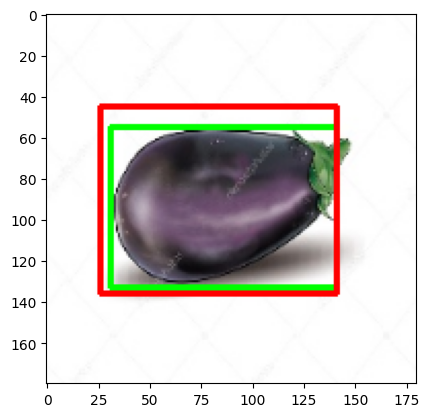

In [19]:
model.load_state_dict(torch.load("best_model.pt"))#load our best weights
model.eval()
with torch.no_grad():
  #image, true_bboxes = trainset[17]
  image, true_bboxes = validset[12]
  #image = image.unsqueeze(0).to(DEVICE)
  image = image.unsqueeze(0)#use unsqueeze(0) because at point validset[1] our image shape is (channel, height, width) so here we're adding batch_size as one at the zeroth axis using unsqueeze and passing the axis #
  #When passing in the image into our model our image tensil should be of (batch_size, channel, height, width) convention
  out_bbox = model(image)#get the predicted bounding box
  utils.compare_plots(image, true_bboxes, out_bbox)#displays the predicted bounding box in red and true bounding box in green
  print(true_bboxes)
  print(out_bbox[0])
  for i in range(len(validset)):
    image, true_bboxes = validset[i]
#green bounding box is the true bounding box
#red bounding box is the predicted bounding box

In [20]:
print(validset[12])
print(true_bboxes)
iou = bounding_box_IOU(true_bboxes, out_bbox)
print(iou)

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1